Anyone with a bank account currently living must have encountered the words 'Transaction Fraud'. It might be their personal experience or a third-party experience heard from someone else or from agents selling insurance. As the world is becoming more and more digital, the transaction frauds are also increasing at a rapid pace. In a study, it is found out that 24 bilion USD is lost due to credit card fraud transactions in one year.Banking and financial institutions are facing severe challenges due to fraudulent transactions. 

To tackle these frauds, there is a need for banks to put strategies in place so that customers' money is not lost. The most common strategy used by banks is put a threshold on transaction amount and any transaction above that amount requires multiple-authentications from customer. This method works well in most of the cases but it is a crude way to make a fraud strategy as it spoils the customer experience. Also having a dumb strategy like this would not work because of the fraudsters' scary ability of adapting to different environments. An evolving and intelligent fraud policy is the best solution to this problem. Machine learning is the perfect answer and algorithms like Boosting and Regression can be used to classify frauds.

Post building a model, we can use this to predict whether a fraud can happen or not and only authenticate a transaction if the model says so. There is another problem that many banks encounter while model implementation that is to run the model on real-time basis and give results instantly. Unlike models to optimize marketing campaigns or determine customer's risk score which can be done in batch, transaction models need to be run on real-time. Hence there is lot of emphasis on big data cloud platforms like AWS, Azure and Hadoop that stores data and implement machine learning models on scale when considering transaction frauds.

This case study aims to answer some of the questions related to transaction frauds using visualizations. Couple of classification models would also be built at the end and the features that drive these models' performance would be explained.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv


Importing necessary packages to visualiza data and build models

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as pl2
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score,classification_report,roc_auc_score,precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense,Input,BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier

## Introduction
Reading the transaction data into a dataframe and checking shape, data types and the summary.

In [3]:
df = pd.read_csv("/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv")
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [5]:
df.shape

(6362620, 11)

In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [8]:
#Total number of unique customers
print(f"Total number of unique customers are {df.nameOrig.nunique()}")
print(f"Total number of unique customers are {df.nameDest.nunique()}")
print(f"Average no. of transactions per customer are {df.shape[0]/df.nameOrig.nunique()}")
print(f"Average no. of transactions per recipient are {df.shape[0]/df.nameDest.nunique()}")

Total number of unique customers are 6353307
Total number of unique customers are 2722362
Average no. of transactions per customer are 1.0014658507766112
Average no. of transactions per recipient are 2.337168973119666


## Issues with the dataset

Simple univariate and bivariate analysis is done on all the variables to diagnose the data. There are primarily four issues with the data.

First, the number of frauds are in avery minute amount in the data. From a logical standpoint, it makes sense and also it is good for the society that there are very less number of frauds happening. But from a modelling and data point of view, less number of events is a troublesome issue and there is a need of solving it before developing the model.

0    6354407
1       8213
Name: isFraud, dtype: int64


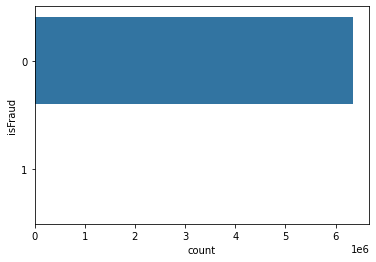

In [9]:
print(df.isFraud.value_counts())
sns.countplot(y="isFraud",data=df)
plt.show()

Secondly, there are very big outliers in the quantitative variables. Generally, very very big outliers are removed because there is a chance that it because of wrong recording. But in this case, wrong recording is not the case because very large frauds transactions tend to happen. So we cannot remove the outliers and there is a need of treating them before analysis or modelling.

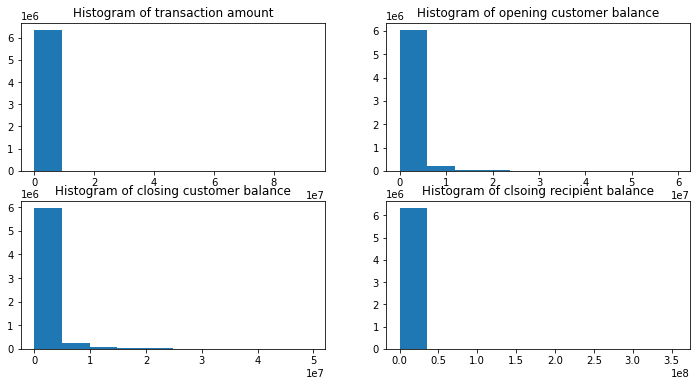

In [10]:
fig,axs = plt.subplots(2,2,figsize=(12,6))
axs[0][0].title.set_text('Histogram of transaction amount')
axs[0][0].hist(df["amount"])
axs[0][1].title.set_text("Histogram of opening customer balance")
axs[0][1].hist(df["oldbalanceOrg"])
axs[1][0].title.set_text("Histogram of closing customer balance")
axs[1][0].hist(df["newbalanceOrig"])
axs[1][1].title.set_text("Histogram of clsoing recipient balance")
axs[1][1].hist(df["newbalanceDest"])
plt.show()

Though there are five transaction types, frauds happened only when the transaction type is TRANSFER or CASH_IN. Frauds happen the most during Payments, Transfers, Cash-outs from customers and Cash-ins to recipients. This trend is not reflected in the data.

<AxesSubplot:ylabel='isFraud'>

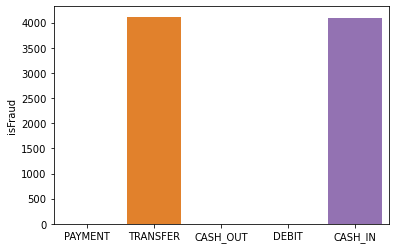

In [11]:
sns.barplot(x=df.type.unique(),y=df.groupby("type")["isFraud"].sum())

 Last but not the least, many variables are not talking with each other. For example, take a transaction from a customer "C1900366749" to recipient "C997608398". The data states that opening customer balance is 4465, closing customer balance is 0, opening recipient balance is 10845, closing recipient balance is 157982.12 and transaction amount is 9644.94. The difference between opening and closing balance of customer, difference between opening and closing balance of recipient and transaction amount must be equal which is not happening for most of the observations. (>85%) Also, the customer's account balance remained same when TRANSFER transactions happened more than 15% of the times. There are multiple reasons this can happen - Different currencies or multiple transactions at the same time or wrong recording. We don't have solution for any of these problems.

In [12]:
print(f"% of transactions where difference between opening and closing balance of customer is not equal to transaction amount is {(1-len(df[np.abs(df.oldbalanceOrg-df.newbalanceOrig) == (df.amount)])/len(df))*100}")
print(f"% of transactions where difference between opening and closing balance of recipient is not equal to transaction amount is {(1-len(df[np.abs(df.oldbalanceDest-df.newbalanceDest) == (df.amount)])/len(df))*100}")
print(f"% of transactions where opening and closing balance of customer is equal to 0 but transaction amount is not equal to 0 is {(1-len(df[(df.oldbalanceOrg==0)&(df.newbalanceOrig==0)&(df.amount!=0)])/len(df))*100}")
print(f"% of transactions where opening and closing balance of recipient is equal to 0 but transaction amount is not equal to 0 is {(1-len(df[(df.oldbalanceDest==0)&(df.newbalanceDest==0)&(df.amount!=0)])/len(df))*100}")
print("% of transfer transactions where the opening and closing balance of the customer remained the same is " + str((len(df[(df.type=="CASH_OUT")&(df.oldbalanceOrg==df.newbalanceOrig)&(df.amount != 0)])/len(df))*100))

% of transactions where difference between opening and closing balance of customer is not equal to transaction amount is 85.39760350295947
% of transactions where difference between opening and closing balance of recipient is not equal to transaction amount is 85.05254124873088
% of transactions where opening and closing balance of customer is equal to 0 but transaction amount is not equal to 0 is 67.16810056234695
% of transactions where opening and closing balance of recipient is equal to 0 but transaction amount is not equal to 0 is 63.57984603826725
% of transfer transactions where the opening and closing balance of the customer remained the same is 16.122053493686565


## Exploratory Data Analysis

Through the exploratory data analysis, we can prove some hypothesis about fraud attacks and get some visual interpretations from data.

One popular trend is fraud attacks by big criminals happen in a short period of time. To check this, we can plot the fraud attacks with time. In our data, we have data every hour. The below graph shows the fraud attack every hour in the 744 hours. As expected there are peaks and troughs and also a very big peak. This suggests that frauds happen in short period of time.

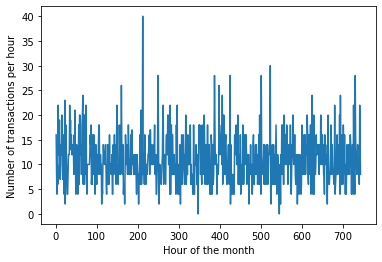

In [13]:
sns.lineplot(x=list(range(1,744)),y=df.groupby("step")["isFraud"].sum())
plt.xlabel("Hour of the month")
plt.ylabel("Number of transactions per hour")
plt.show()

Another analysis that can be interesting is at which hour of a day, the fraud attacks generally happen. From the step variable, we can get the hour of day. The below plot shows the frauds at different hours of day. It tells that frauds happen during sleeping hours the most. Close to 20% of transactions that happen during 4 AM and 5 AM are fraud transactions.

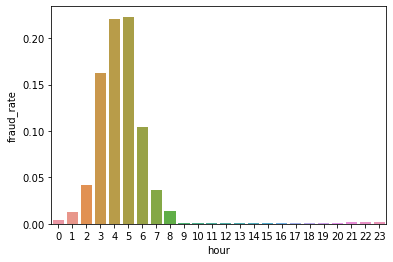

In [14]:
df["hour"] = df.step % 24
frauds_hour = pd.concat([df.groupby("hour")["isFraud"].sum(),df.groupby("hour")["isFraud"].count()],axis=1)
frauds_hour.columns = ["Frauds","Transactions"]
frauds_hour["fraud_rate"] = frauds_hour.Frauds/frauds_hour.Transactions
sns.barplot(x=frauds_hour.index,y=frauds_hour.fraud_rate)
plt.show()

We can look at the transaction amount and customer's opening balance for fraud and non-fraud cash-out and tranfer transactions seperately. Median for these variables are compared because mean is biased because of outliers. From the plots, we can see that these variables are abnormally high for fraud cash-out transactions compared to non-fraud cash-out transactions.

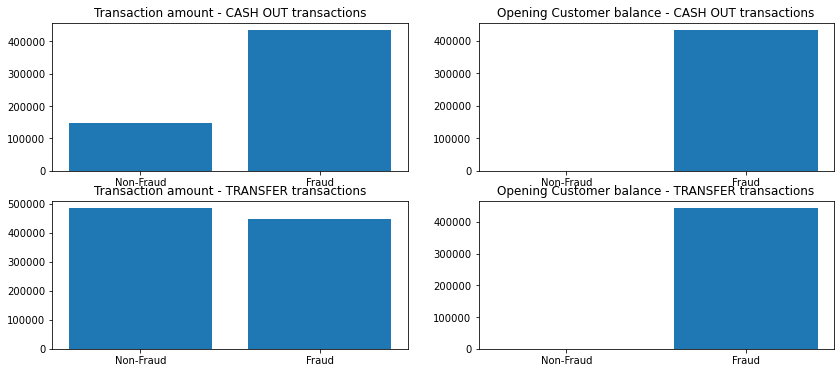

In [15]:
fig,ax=plt.subplots(2,2,figsize=(14,6))
ax[0][0].title.set_text("Transaction amount - CASH OUT transactions")
ax[0][0].bar(x=["Non-Fraud","Fraud"],height=df[df.type=="CASH_OUT"].groupby("isFraud")["amount"].median())
ax[0][1].title.set_text("Opening Customer balance - CASH OUT transactions")
ax[0][1].bar(x=["Non-Fraud","Fraud"],height=df[df.type=="CASH_OUT"].groupby("isFraud")["oldbalanceOrg"].median())
ax[1][0].title.set_text("Transaction amount - TRANSFER transactions")
ax[1][0].bar(x=["Non-Fraud","Fraud"],height=df[df.type=="TRANSFER"].groupby("isFraud")["amount"].median())
ax[1][1].title.set_text("Opening Customer balance - TRANSFER transactions")
ax[1][1].bar(x=["Non-Fraud","Fraud"],height=df[df.type=="TRANSFER"].groupby("isFraud")["oldbalanceOrg"].median())
fig.show()

We can look at the recipient's opening balance for fraud and non-fraud cash-out and transfer transactions seperately. From the plots, we can see that this variable is very less for transfer fraud transactions compared to transfer non-fraud transactions which is reverse of what we observed in customer balance.

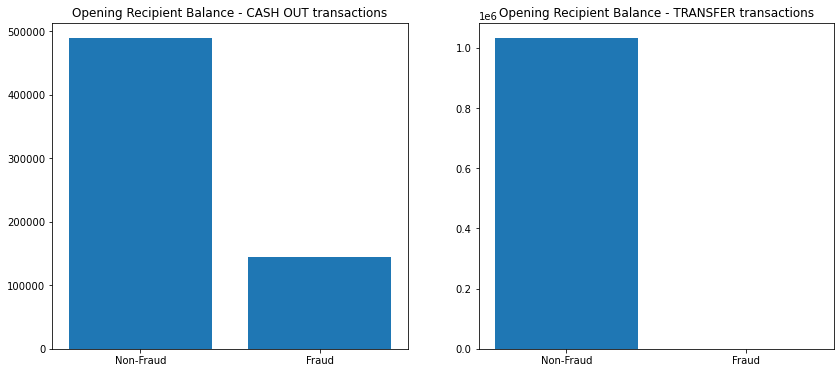

In [16]:
fig,ax=plt.subplots(1,2,figsize=(14,6))
ax[0].title.set_text("Opening Recipient Balance - CASH OUT transactions")
ax[0].bar(x=["Non-Fraud","Fraud"],height=df[df.type=="CASH_OUT"].groupby("isFraud")["oldbalanceDest"].median())
ax[1].title.set_text("Opening Recipient Balance - TRANSFER transactions")
ax[1].bar(x=["Non-Fraud","Fraud"],height=df[df.type=="TRANSFER"].groupby("isFraud")["oldbalanceDest"].median())
fig.show()

As mentioned in the issues sections, there is a need of outlier treatment in the quantitative variables. Two popular ways to treat the outliers are transformations and capping. For transformation, Log(1+x) is a decent one when there are zeroes present in the variable and 3xp75 is a good cut-off for capping. The box plots for one variable 'amount' are shown below pre and post transformations.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


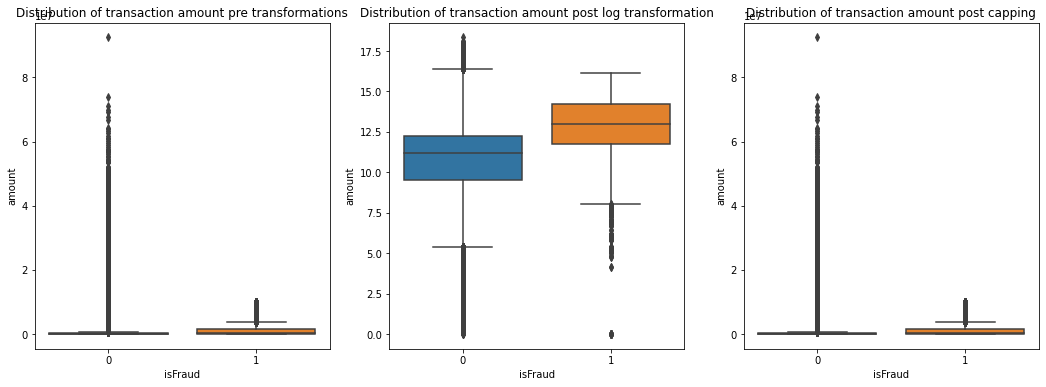

In [17]:
fig,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].title.set_text("Distribution of transaction amount pre transformations")
ax[1].title.set_text("Distribution of transaction amount post log transformation")
ax[2].title.set_text("Distribution of transaction amount post capping")
sns.boxplot(x=df.isFraud, y=df.amount,ax=ax[0])
sns.boxplot(x=df.isFraud,y=np.log1p(df.amount),ax=ax[1])
df1 = df.copy()
df1[df1.amount > df1.amount.quantile(0.75)*3]["amount"] = df1.amount.quantile(0.75)*3
sns.boxplot(x=df1.isFraud,y=(df1.amount),ax=ax[2])
plt.show()

The below plot shows the total fraud transaction amount on a daily basis

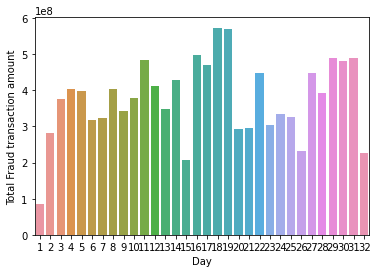

In [18]:
df["day"] = round(df.step/24)
sns.barplot(x=list(range(1,33)),y=df[df.isFraud==1].groupby("day")["amount"].sum())
plt.xlabel("Day")
plt.ylabel("Total Fraud transaction amount")
plt.show()

We can also see the fraud transactions per day of the week.

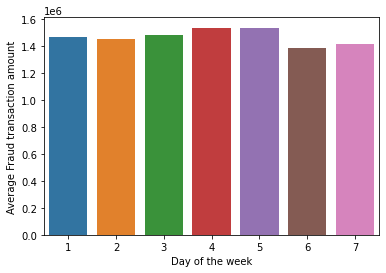

In [19]:
df["dayweek"] = df.day % 7
sns.barplot(x=list(range(1,8)),y=df[df.isFraud==1].groupby("dayweek")["amount"].mean())
plt.xlabel("Day of the week")
plt.ylabel("Average Fraud transaction amount")
plt.show()

## Data Cleaning

Before model development, we need to clean the data i.e. deal with missing values and outliers. Since the missing values are 0 in all the columns, there is no need to handle them.

For outlier treatment, capping will not be done on the quantitative variables as we can lose some information because frauds happen at high transactions. Log transformed variables and the original variables both will also be used in the model and the algorithm decides which variable is better.

Other issues with the data (variables not talking with each other) can also be dealt with if more information is present. The less event rate is handled during model development using sampling techniques.

## Feature Generation

There are 5 numeric features, 1 categorical feature and 1 datetime feature that we can use in the model. In this section, the three different feature types would be explored.

In [20]:
df1 = df.copy()

### Datetime features

'Step' is the only datetime feature. Hour of the day, Day of the week, Day of the month, Week of the month variables are created in this exercise. Codes are written below. Some other variables that can be created are day to hour transactions, day to hour fraud transactions and hours since last fraud transaction.

In [21]:
df1["hourday"] = df1.step % 24
df1["hourweek"] = df1.step % (24*7)
df1["day"] = round(df1.step/24)
df1["dayweek"] = df1.day % 7
df1["daymonth"] = df1.day % 30

### Categorical Features

There are three categorical features present in the data - 'type', 'nameOrig' and 'nameDest'. 'nameOrig' and 'nameDest' are ignored during this exercise because it is very memory and time-consuming to work with millions of unique categories. Only 'type' is handled using get_dummies() function of pandas. Code and output is given below. Provided there are no space and processing power issues, variables like number of cash-in/cash-out/etc. transactions made by a customer during last hour/3 hours/6 hours/1 day can be calculated.

In [22]:
df1 = pd.get_dummies(df1,columns=["type"])
df1.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,...,day,dayweek,hourday,hourweek,daymonth,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,...,0.0,0.0,1,1,0.0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,...,0.0,0.0,1,1,0.0,0,0,0,1,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,...,0.0,0.0,1,1,0.0,0,0,0,0,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,...,0.0,0.0,1,1,0.0,0,1,0,0,0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,...,0.0,0.0,1,1,0.0,0,0,0,1,0


### Quantitative Features

As seen in the issues section, difference between opening and closing balance should give the transaction amount. As fraud also can be a reason why there is such a differnce, creating such variables would be useful. Also log transformations as explained in the previous section also would be created. Ratio between different balances can also turn out to be useful. One is added to denominator to handle the missing values Interaction variables with 'type' can be created. Binned quantitative variables also sometimes give a good result in case of regression modelling.

In [23]:
df1["logamount"] = np.log1p(df1["amount"])
df1["logoldbalanceOrg"] = np.log1p(df1["oldbalanceOrg"])
df1["lognewbalanceOrig"] = np.log1p(df1["newbalanceOrig"])
df1["logoldbalanceDest"] = np.log1p(df1["oldbalanceDest"])
df1["lognewbalanceDest"] = np.log1p(df1["newbalanceDest"])
df1["custdiff"] = df1["oldbalanceOrg"] - df1["newbalanceOrig"]
df1["destdiff"] = df1["oldbalanceDest"] - df1["newbalanceDest"]
df1["custind"] = np.where(df1["oldbalanceOrg"] - df1["newbalanceOrig"] == df1.amount,1,0)
df1["destind"] = np.where(df1["oldbalanceDest"] - df1["newbalanceDest"] == df1.amount,1,0)
df1["custrto"] = df1.oldbalanceOrg/(df1.newbalanceOrig+1)
df1["destrto"] = df1.oldbalanceDest/(df1.newbalanceDest+1)
df1["custdestrto1"] = df1.oldbalanceOrg/(df1.oldbalanceDest+1)
df1["custdestrto2"] = df1.newbalanceOrig/(df1.newbalanceDest+1)
df1["custamountrto"] = df1.oldbalanceOrg/(df1.amount+1)
df1["destamountrto"] = df1.oldbalanceDest/(df1.amount+1)

We can also drop some the ID Variables from the dataset

In [24]:
df1 = df1.drop(["isFlaggedFraud","nameOrig","nameDest"],axis=1)

## Model Development

Prior to model development the dataset need to be divided into train and test samples. In this case, since the modelling dataset is huge, model will be built on a 25% sample only. Post sampling, ~1.1M samples are present in train dataset. Stratify option in train_test_split is used to make sure that the fraud cases are also divided randomly. Code to create train and test samples is given below.

In [25]:
X1,X2,y1,y2 = train_test_split(df1.drop("isFraud",axis=1),df1["isFraud"],test_size=0.75,random_state=1234,stratify = df1["isFraud"])
X_train,X_test,y_train,y_test = train_test_split(X1,y1,test_size=0.75,random_state=1234,stratify = y1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(397663, 32)
(1192992, 32)
(397663,)
(1192992,)


Three different algorithms are used to build a model during this case study - Decision Tree, Logistic Regression, and GBM. To deal with skewed data, the most popular methods like Undersampling, oversampling and SMOTE can be used. Undersampling removes records of the majority class randomly and oversampling duplicates the records of minority class. SMOTE is a modelling technique that generates new minority class records and the most accurate. Since SMOTE is a modelling technique that takes lot of time and oversampling increases the already large sample size, undersampling is used in this exercise. Algorithms like Random Forest and LightGBM have inbuilt weight adjusting parameters to deal with skewed data.

### Decision Tree Classifier

A simple decision tree classifier with a depth of 6 is built. The code and decision tree is shown below.

In [26]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as pl2

dt = pl2([
    ('sampler',RandomUnderSampler(random_state=1234,sampling_strategy='majority')),
    ('clf',DecisionTreeClassifier(max_depth=6))
    ])

dt.fit(X_train,y_train)

Pipeline(steps=[('sampler',
                 RandomUnderSampler(random_state=1234,
                                    sampling_strategy='majority')),
                ('clf', DecisionTreeClassifier(max_depth=6))])

[Text(618.0923076923077, 504.7714285714286, 'custind <= 0.5\ngini = 0.5\nsamples = 1026\nvalue = [513, 513]'),
 Text(463.5692307692308, 427.11428571428576, 'custdiff <= 718615.906\ngini = 0.021\nsamples = 481\nvalue = [476, 5]'),
 Text(386.3076923076923, 349.4571428571429, 'custdestrto1 <= 2905408.25\ngini = 0.012\nsamples = 479\nvalue = [476, 3]'),
 Text(309.04615384615386, 271.8, 'step <= 22.0\ngini = 0.008\nsamples = 478\nvalue = [476, 2]'),
 Text(231.7846153846154, 194.14285714285717, 'hourweek <= 20.5\ngini = 0.083\nsamples = 46\nvalue = [44, 2]'),
 Text(154.52307692307693, 116.48571428571432, 'custdestrto1 <= 0.001\ngini = 0.043\nsamples = 45\nvalue = [44, 1]'),
 Text(77.26153846153846, 38.82857142857142, 'gini = 0.153\nsamples = 12\nvalue = [11, 1]'),
 Text(231.7846153846154, 38.82857142857142, 'gini = 0.0\nsamples = 33\nvalue = [33, 0]'),
 Text(309.04615384615386, 116.48571428571432, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(386.3076923076923, 194.14285714285717, 'gini 

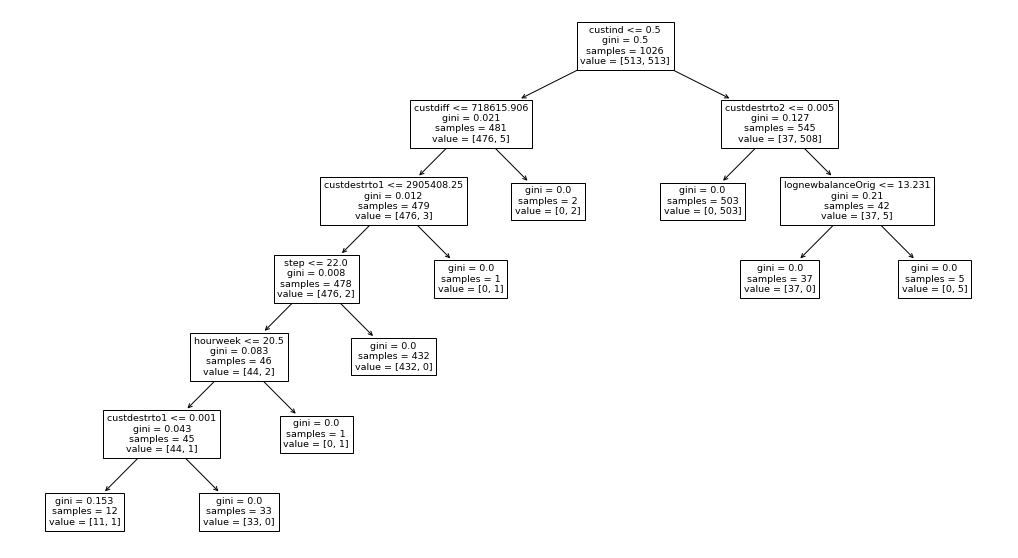

In [27]:
plt.subplots(figsize=(18,10))
plot_tree(dt['clf'],feature_names = X_train.columns)

### Logistic Regression Classifier

Logistic regression model without regularization is built with all the variables inputted. Multiple iterations to remove multi-collinearity and variables with high p-values need to be done on logistic regression equation to get the best model. In this case, only iteration is done

In [28]:
logreg = pl2([
    ('stdize',StandardScaler()),
    ('sampler',RandomUnderSampler(random_state=1234,sampling_strategy='majority')),
    ('clf',LogisticRegression(max_iter=1000000))
    ])
logreg.fit(X_train,y_train)

Pipeline(steps=[('stdize', StandardScaler()),
                ('sampler',
                 RandomUnderSampler(random_state=1234,
                                    sampling_strategy='majority')),
                ('clf', LogisticRegression(max_iter=1000000))])

In [29]:
pd.DataFrame({"Variable":list(X_train.columns),"Coefficient":logreg['clf'].coef_[0]})

,Variable,Coefficient
0,step,0.151348
1,amount,0.204482
2,oldbalanceOrg,0.081109
3,newbalanceOrig,0.011541
4,oldbalanceDest,-0.247352
5,newbalanceDest,-0.334640
6,hour,-0.193112
7,day,-0.000919
8,dayweek,-0.232777
9,hourday,-0.193112


### Gradient Boosting Classifier

A cross validation GBM model is built with little hyperparameter tuning. AUC is used to select the best model from the different cross-validation folds. Top 10 most important variables are also plotted.

In [30]:
pl = pl2([
    ('sampler',RandomUnderSampler(random_state=1234,sampling_strategy='majority')),
    ('clf',GradientBoostingClassifier(max_features='sqrt',subsample=0.7))
    ])
parameters = {'clf__learning_rate':[0.07,0.1],
              'clf__n_estimators':[300,500],
              'clf__max_depth':[5]
    }

cv = GridSearchCV(pl,parameters,scoring="roc_auc",verbose=True,n_jobs=6)
cv.fit(X_train,y_train)
print(cv.best_params_)
print(cv.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 500}
0.9981364552533891


<AxesSubplot:xlabel='Importance', ylabel='Variable'>

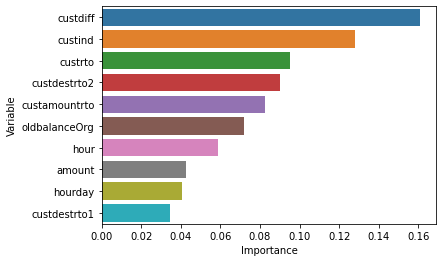

In [31]:
imp = pd.DataFrame({"Variable":list(X_train.columns),"Importance":cv.best_estimator_['clf'].feature_importances_})
imp = imp.sort_values("Importance",ascending=False)
sns.barplot(x=imp.Importance.head(10),y=imp.Variable.head(10))

## Model Performance

Since we are dealing with skewed data, accuracy is not a suitable metric to compare model performances. F1 score and AUC are better metrics in this case.

In [32]:
from sklearn.metrics import f1_score,classification_report,roc_auc_score
print(f"F1 score of decision tree classifier is {f1_score(dt.predict(X_test),y_test)}")
print(f"F1 score of GBM classifier is {f1_score(cv.best_estimator_.predict(X_test),y_test)}")
print(f"F1 score of logistic regression classifier is {f1_score(logreg.predict(X_test),y_test)}")
print(f"AUC of decision tree classifier is {roc_auc_score(dt.predict(X_test),y_test)}")
print(f"AUC of GBM classifier is {roc_auc_score(cv.best_estimator_.predict(X_test),y_test)}")
print(f"AUC of logistic regression classifier is {roc_auc_score(logreg.predict(X_test),y_test)}")

F1 score of decision tree classifier is 0.2543545295441286
F1 score of GBM classifier is 0.8163374265883608
F1 score of logistic regression classifier is 0.533496589120168
AUC of decision tree classifier is 0.5729456055058519
AUC of GBM classifier is 0.8465502316099742
AUC of logistic regression classifier is 0.6825409739355035


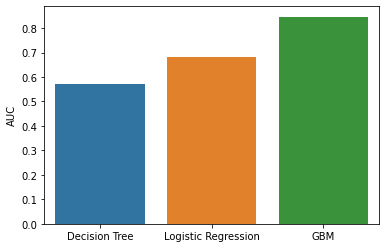

In [33]:
sns.barplot(x=["Decision Tree","Logistic Regression","GBM"],
            y=[roc_auc_score(dt.predict(X_test),y_test),roc_auc_score(logreg.predict(X_test),y_test),
               roc_auc_score(cv.best_estimator_.predict(X_test),y_test)])
plt.ylabel("AUC")
plt.show()

As we can see, GBM model is performing the best out of the three models in terms of F1 score and AUC. Precision and recall can also be calculated and compared depending on the business requirements. If the business values loss remedy more than anything else, recall is the metric to go to becasue we can get how many actual frauds are captured. If customer experience matters, we can check precision. Depending on what we need to maximize - precision or recall, the right cut-off for probabilities can be selected.

In the below case, for GBM model precision and recall of thresholds 0.5 and 0.95 are compared.

In [34]:
dt_probs = pd.DataFrame({"Actual":y_test,"Predicted":cv.best_estimator_.predict_proba(X_test)[:,1],"Amount":X_test.amount})
dt_probs["Predicted_95"] = np.where(dt_probs.Predicted > 0.95,1,0)
dt_probs["Predicted_50"] = np.where(dt_probs.Predicted > 0.5,1,0)
#cut - probability greater than 0.5
print("Precision for threshold = 0.5 is "+ str(precision_score(dt_probs["Predicted_50"],y_test)))
print("Recall for threshold = 0.5 is "+ str(recall_score(dt_probs["Predicted_50"],y_test)))
#cut - probability greater than 0.95
print("Precision for threshold = 0.95 is "+ str(precision_score(dt_probs["Predicted_95"],y_test)))
print("Recall for threshold = 0.95 is "+ str(recall_score(dt_probs["Predicted_95"],y_test)))

Precision for threshold = 0.5 is 0.9928571428571429
Recall for threshold = 0.5 is 0.6931097008159565
Precision for threshold = 0.95 is 0.9922077922077922
Recall for threshold = 0.95 is 0.8153681963713981


We can also calculate the extra frauds captured and hence money saved compared to the default strategy - amount greater than 200,000 (mentioned in the data problem statement).

In [35]:
#Frauds captured by "Amount > 200,000" strategy
print("% Frauds captured by 'Amount > 200,000' strategy in number and amount")
print(len(dt_probs[(dt_probs.Amount > 200000) & (dt_probs.Actual==1)])/len(dt_probs[dt_probs.Actual==1]))
print(sum(dt_probs[(dt_probs.Amount > 200000) & (dt_probs.Actual==1)]["Amount"])/sum(dt_probs[dt_probs.Actual==1]["Amount"]))
print("% Frauds captured by GBM model in number and amount")
print(len(dt_probs[(dt_probs.Predicted_50 == 1) & (dt_probs.Actual==1)])/len(dt_probs[dt_probs.Actual==1]))
print(sum(dt_probs[(dt_probs.Predicted_50 == 1) & (dt_probs.Actual==1)]["Amount"])/sum(dt_probs[dt_probs.Actual==1]["Amount"]))

% Frauds captured by 'Amount > 200,000' strategy in number and amount
0.6610389610389611
0.9814119047100848
% Frauds captured by GBM model in number and amount
0.9928571428571429
0.9962618769212719


Incremental benefit in both number are amount for test population is given below

In [36]:
print("The fraud losses saved due to using GBM model is")
print(sum(dt_probs[(dt_probs.Predicted_50 == 1) & (dt_probs.Actual==1)]["Amount"]) - sum(dt_probs[(dt_probs.Amount > 200000) & (dt_probs.Actual==1)]["Amount"]))
print("Incremental beneift in number of frauds captured")
print(len(dt_probs[(dt_probs.Predicted_50 == 1) & (dt_probs.Actual==1)]["Amount"]) - len(dt_probs[(dt_probs.Amount > 200000) & (dt_probs.Actual==1)]["Amount"]))

The fraud losses saved due to using GBM model is
34038825.03999996
Incremental beneift in number of frauds captured
511


## Proposals to improve the model
• Run the entire process above on PySpark instead of Python which saves lot of time and memory.

• Explore other outlier treatment techniques to handle the quantitative variables in a better manner.

• Get more data and information to solve the problem of '2 variables not talking with each other' issue.

• More variables can be created as mentioned in the feature generation section.

• Sampling techniques other than Undersampling can be used and the best model can be taken.

• Hyperparameter tuning is not done on any model. There is still lot of scope of improvement by tuning the models.

• Selecting the best model based out of precision and recall rather than AUC and F-1 score